# Attenuated RHESSI example {[Download data files here](https://drive.google.com/file/d/1FMRVh8E0jCh3mj15r_Fy8g_RhbmlGIj-)}
This is looking at the M9 class flare observed by RHESSI from [Knuth+Glesener 2020](https://iopscience.iop.org/article/10.3847/1538-4357/abb779).
We perform spectroscopy on the interval where the thick attenuator is inserted.


## Important note on systematic error
- Systematic error is important to add to RHESSI data so that the minimizer has some wiggle room.

In [1]:
from sunxspex.sunxspex_fitting import fitter
from sunxspex.sunxspex_fitting import instruments as instr

import astropy.time as atime
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Notice the warning about attenuator changes!

In [2]:
spec_fn = 'rhessi-data/rhessi-2011-jul-stixbins-spec.fits'
srm_fn = spec_fn.replace('spec', 'srm')
rl = instr.RhessiLoader(spectrum_fn=spec_fn, srm_fn=srm_fn)

/Users/settwi/grad_school/glesener/fit-support-code/sunxspex/sunxspex/sunxspex_fitting/instruments.py:617: UserWarning: 
do not update event times to (2011-07-30T01:50:00.000, 2011-07-30T02:30:00.000): covers attenuator state change. Don't trust this fit!
  warnings.warn(


### Notice there is no warning when the fit interval doesn't cover a time range!

In [3]:
rl.update_event_times(atime.Time('2011-07-30T02:08:20'), atime.Time('2011-07-30T02:10:20'))
end_background_time = '2011-07-30T01:56:00'
start_background_time = '2011-07-30T01:54:00'
rl.update_background_times(atime.Time(start_background_time), atime.Time(end_background_time))

<Axes: title={'center': 'RHESSI Lightcurve'}, xlabel='Time (Start Time: 2011-07-30T01:50:00.000)', ylabel='Counts s$^{-1}$'>

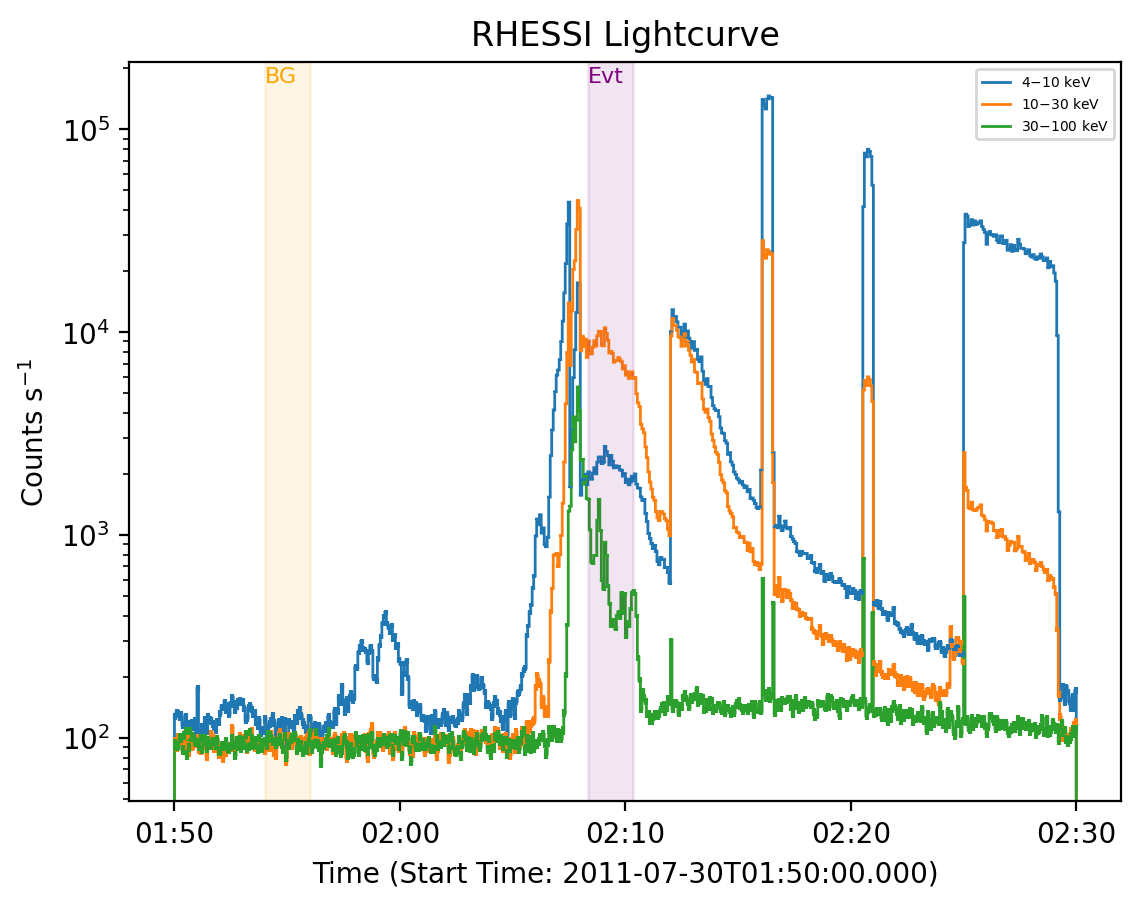

In [4]:
plt.figure()
rl.lightcurve(energy_ranges=[[4, 10], [10, 30], [30, 100]])

### Add systematic error before passing to the fitter object

In [5]:
# Uniform 10%
rl.systematic_error = 0.1

In [6]:
ss = fitter.SunXspex(rl)
ss.energy_fitting_range = [5, 70]

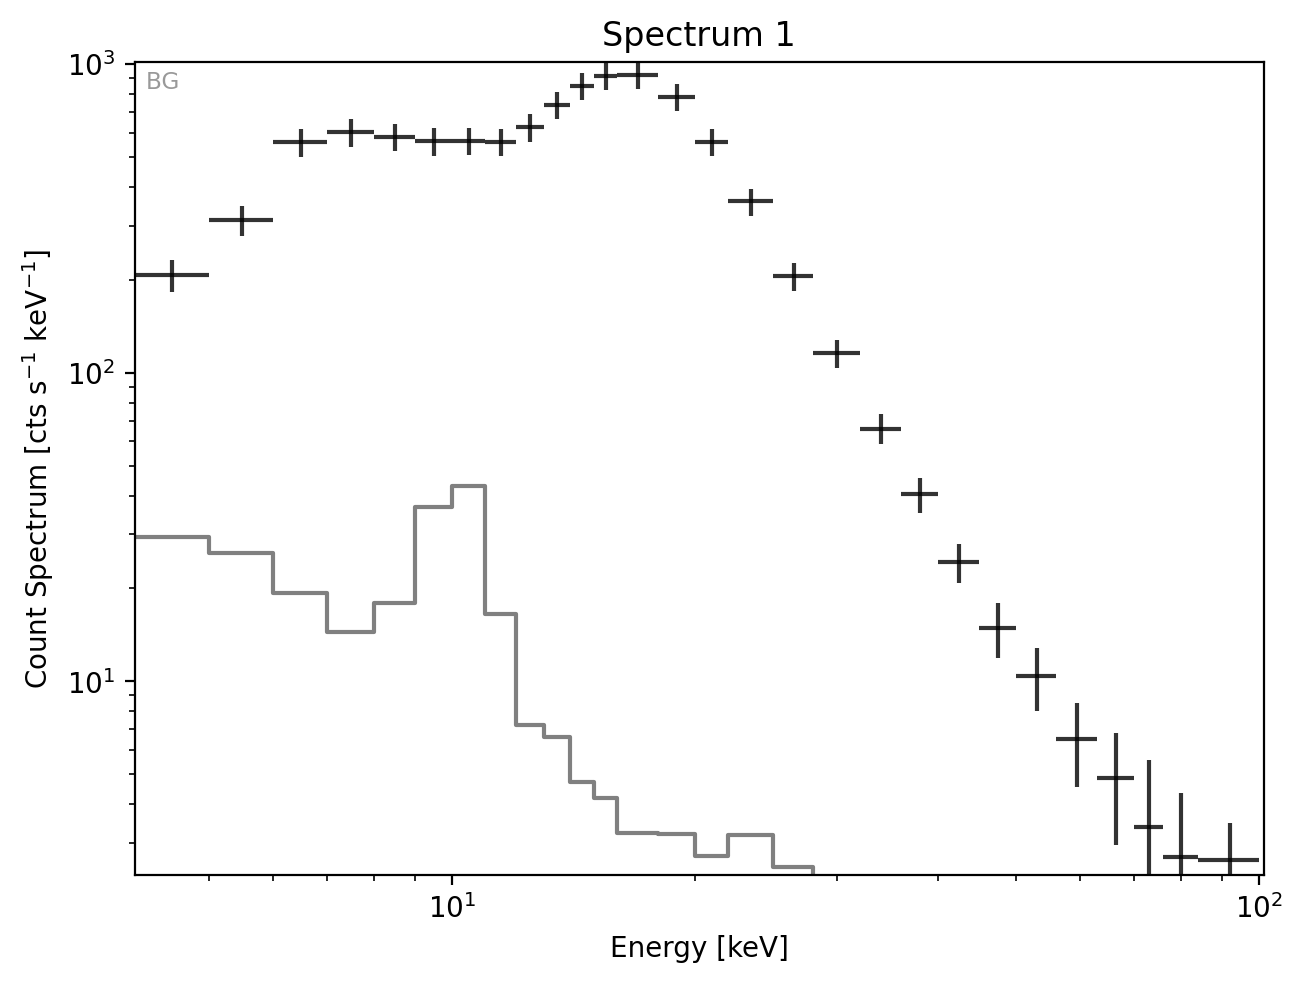

In [7]:
plt.figure(layout='constrained')
axs, *_ = ss.plot()
_ = axs[0].set(xscale='log')

### Fit the spectrum with a double thick target electron power law

In [8]:
def double_thick(electron_flux, low_index, break_energy, up_index, low_cutoff, up_cutoff, energies=None):
    from sunxspex.emission import bremsstrahlung_thick_target
    mids = np.mean(energies, axis=1)
    flux = bremsstrahlung_thick_target(
        photon_energies=mids,
        p=low_index,
        eebrk=break_energy,
        q=up_index,
        eelow=low_cutoff,
        eehigh=up_cutoff,
    )
    
    # scale to good units
    return 1e35 * electron_flux * flux

In [9]:
ss.add_photon_model(double_thick, overwrite=True)

2023-11-15T18:00:14Z INFO sunxspex.sunxspex_fitting.fitter 739: Model double_thick added.


In [10]:
ss.loglikelihood = 'chi2'
ss.model = 'f_vth + double_thick'

In [11]:
th_params = [
    'T1_spectrum1',
    'EM1_spectrum1',
]
nth_params = [
    'electron_flux1_spectrum1',
    'low_index1_spectrum1',
    'up_index1_spectrum1',
    'break_energy1_spectrum1',
    'low_cutoff1_spectrum1',
    'up_cutoff1_spectrum1',
]

In [12]:
ss.params['T1_spectrum1'] = ['free', 20, (5, 100)]
ss.params['EM1_spectrum1'] = ['free', 5000, (500, 100000)]

ss.params['electron_flux1_spectrum1'] = ['free', 10, (1, 50)]
ss.params['low_index1_spectrum1'] = ['free', 5, (1, 20)]
ss.params['up_index1_spectrum1'] = ['free', 5, (1, 20)]

ss.params['break_energy1_spectrum1'] = ['free', 40, (40, 100)]
ss.params['low_cutoff1_spectrum1'] = ['free', 20, (5, 39)]
ss.params['up_cutoff1_spectrum1'] = ['frozen', 500, (5, 1000)]

### Only thermal params vary first

In [13]:
for p in th_params:
    ss.params[p] = 'free'
for p in nth_params:
    ss.params[p] = 'frozen'

In [14]:
_ = ss.fit()

### Only nonthermal params vary now

In [15]:
for p in th_params:
    ss.params[p] = 'frozen'
for p in nth_params:
    ss.params[p] = 'free'

In [16]:
_ = ss.fit()

### All params are free to vary

In [17]:
for p in th_params + nth_params:
    ss.params[p] = 'free'

In [18]:
_ = ss.fit()

[None]

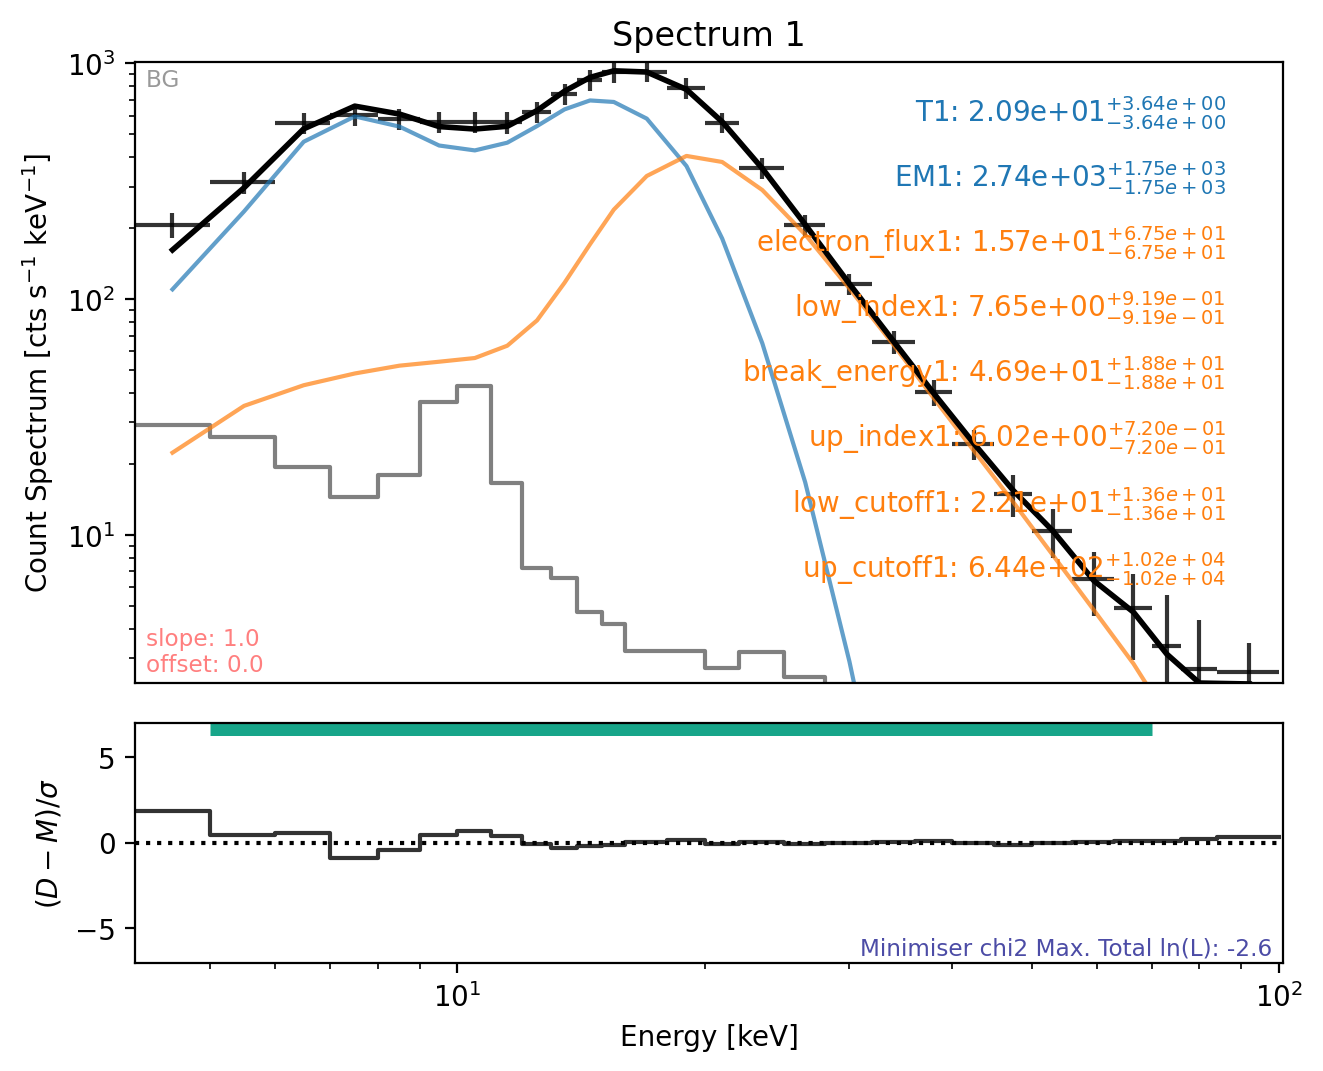

In [19]:
plt.figure(layout='constrained')
ss.plot()
plt.gca().set(xscale='log')

### Now you can run MCMC if you want

In [20]:
# ss.run_mcmc()